### Fully Connected Neural Network

In [8]:
import probflow as pf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch

plt.rcParams['axes.grid'] = False
warnings.filterwarnings('ignore')
pf.set_backend('pytorch')

rand = lambda *x : np.random.rand(*x).astype('float32')
randn = lambda *x : np.random.randn(*x).astype('float32')
zscore = lambda x : (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

N = 1024
x = 10 * rand(N, 1) - 5
y = np.sin(x) / (1 + x*x) + 0.05 * randn(N, 1)

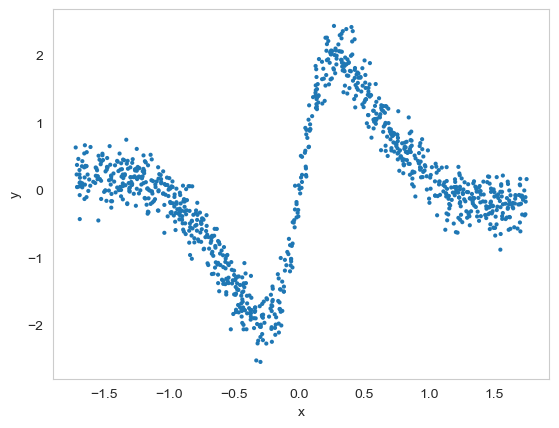

In [9]:
x = zscore(x)
y = zscore(y)

plt.scatter(x, y, marker = '.', edgecolor = 'none')
plt.grid(False)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
class DenseLayer(pf.Module) :
    def __init__(self, d_in, d_out):
        self.w = pf.Parameter([d_in, d_out])
        self.b = pf.Parameter([1, d_out])
    
    def __call__(self, x) :
        return x @ self.w() + self.b()
    
class DenseNetwork(pf.Module) :
    def __init__(self, dims):
        Nl = len(dims) - 1 # number of layers
        self.layers = [DenseLayer(dims[i], dims[i + 1]) for i in range(Nl)]
        self.activations = (Nl - 1)*[torch.nn.ReLU()] + [lambda x : x]
    
    def __call__(self, x):
        for i in range(len(self.activations)) :
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

class DenseRegression(pf.ContinuousModel) :
    def __init__(self, dims) :
        self.net = DenseNetwork(dims)
        self.s = pf.ScaleParameter([1, 1])
    
    def __call__(self, x):
        x = torch.tensor(x)
        return pf.Normal(self.net(x), self.s())

In [11]:
model = DenseRegression([1, 32, 32, 1])
model.fit(x, y, epochs = 1000, lr = 0.02)

In [12]:
x_test = np.linspace(min(x), max(x), 101).astype('float32').reshape(-1, 1)
predicted = model.predict(x_test)

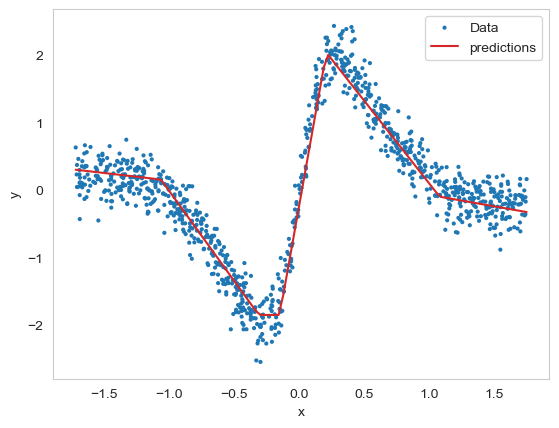

In [13]:
plt.scatter(x, y, marker = '.', edgecolor = 'none', label = 'Data')
plt.plot(x_test, predicted, 'tab:red', label = 'predictions')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
lower, upper = model.predictive_interval(x_test, ci = 0.95)

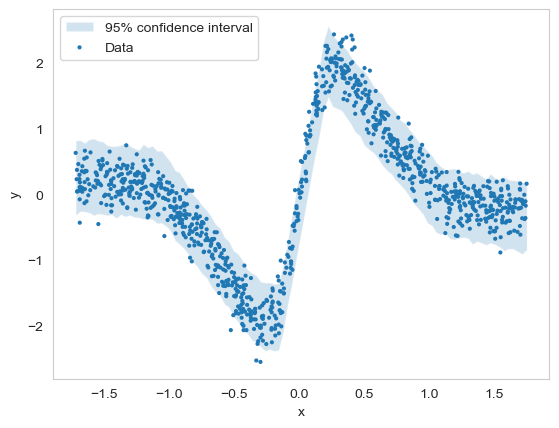

In [16]:
plt.fill_between(
    x_test[:, 0],
    lower[:, 0],
    upper[:, 0],
    alpha = 0.2,
    label = '95% confidence interval'
)
plt.scatter(
    x, y, 
    marker = '.', 
    edgecolor = 'none', 
    label = 'Data',
    color = 'tab:blue'
)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
class DenseRegression(pf.Model) :
    def __init__(self, d_in) :
        self.net = pf.Sequential(
            [
                pf.Dense(d_in, 32),
                torch.nn.ReLU(),
                pf.Dense(32, 32),
                torch.nn.ReLU(),
                pf.Dense(32, 1),
            ]
        )
        self.s = pf.ScaleParameter()
    
    def __call__(self, x) :
        x = torch.tensor(x)
        return pf.Normal(self.net(x), self.s())

In [18]:
model = DenseRegression(1)
model.fit(x, y)